### 正则化

1. 上一部分介绍了逻辑斯蒂回归，但是没有介绍到用的例子仍然是线性可分的，这节我们换用另外一个例子，来说明逻辑斯蒂回归可用于线性不可分的情况。
2. 在复杂分类情况下， 有三种情况：分别是欠拟合（高偏差）、拟合良好、过拟合（高方差），其中正则化主要是用来解决过拟合问题。
3. 正则化：  
正则化主要是用来解决过拟合现象。过拟合现象之所以出现，是因为特征选取过多。所以解决办法首先就是剔除部分特征，另外一种办法就是正则化。其原理是通过对高阶项进行惩罚，减少高阶项的权重，但是在实际过程中，我们往往不知道哪些特征对应的高阶项，因此就对所有权重施加惩罚。具体公式为：
$$
\begin{align}
J(w) &= \sum_{i=1}^{n}y^{(i)}log(\phi(z(x^{(i)})))+(1-y^{(i)})log(1-\phi(z(x^{(i)}))) + \frac{\lambda}{2}\|w\|^2 \\
&= C(\sum_{i=1}^{n}y^{(i)}log(\phi(z(x^{(i)})))+(1-y^{(i)})log(1-\phi(z(x^{(i)})))) + \frac{1}{2}\|w\|^2 \\
\end{align}
$$
其中$C=\frac{1}{\lambda}$，也是scikit-learn中的参数，代表了正则化的强度，其中$C$越大，正则化强度越小。   
根据上一节我们推导的逻辑斯蒂回归的代价函数，可得
$$
J(w)= C(\sum_{i=1}^{n}y^{(i)}log(\phi(z(x^{(i)})))+(1-y^{(i)})log(1-\phi(z(x^{(i)})))) + \|w\|
$$
权重更新公式为：
$$
w_j := w_j + C\eta \sum_{i}(y^{(i)}-\phi (z^{(i)})x^{(i)}_j - w_j(j\ne0) \\
w_0 := w_0 + C\eta \sum_{i}(y^{(i)}-\phi (z^{(i)})(j=0)
$$
4. 本次仍然以吴恩达的机器学习课程中的数据为基础进行训练。

#### 数据读取

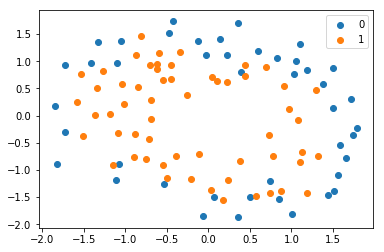

In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

df = pd.read_csv('ex2data2.txt', delimiter=",", header=0)

X = df.iloc[0:100,[0,1]].values
Y = df.iloc[0:100,2].values

# 对数据进行标准化
X[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:,0].std()
X[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:,1].std()
# 绘图

%matplotlib inline
ax = plt.axes()

ax.scatter(X[Y==0,0],X[Y==0,1],label='0')
ax.scatter(X[Y==1,0],X[Y==1,1],label='1')
ax.legend()

1. 从上图中可以看出这是非线性化的数据，那么我们就需要构造一个高阶多项式，然后交由逻辑斯蒂回归拟合。
2. 下面我们**先不进行多项式构造**，先看下分类效果

d:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


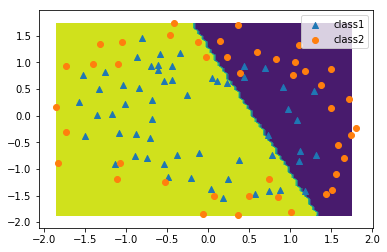

In [2]:
from sklearn.linear_model import LogisticRegression
# 迭代次数
iter_nums = 100
# 正则化强度lambda
lama = 0.1
lr = LogisticRegression(C=1/lama, max_iter=iter_nums, random_state=0)
lr.fit(X, Y)

# 生成预测数据
interval = 0.05
x0_min, x0_max = X[:, 0].min(),X[:, 0].max()
x1_min, x1_max = X[:, 1].min(),X[:, 1].max()
xy, yx = np.meshgrid(np.arange(x0_min, x0_max, interval),
                    np.arange(x1_min, x1_max,interval))
z = np.array([xy.ravel(), yx.ravel()]).T
# 预测
z_predict = []
for x in z:
    z_predict.append(lr.predict(x.reshape(1,-1)))
    
z_predict = np.array(z_predict).reshape(xy.shape)

# 绘制结果
plt.contourf(xy, yx, z_predict)
# 绘制原始数据
plt.scatter(X[Y == 1,0], X[Y == 1,1], marker='^', label='class1')
plt.scatter(X[Y == 0,0], X[Y == 0,1], marker='o', label='class2')
plt.legend()
plt.show()

可以看到线性是无法满足此类情况下的分类的

### 吴恩达-将x1,x2扩展为6维，将其改写为python代码
```matlab
function out = mapFeature(X1, X2)
% MAPFEATURE Feature mapping function to polynomial features
%
%   MAPFEATURE(X1, X2) maps the two input features
%   to quadratic features used in the regularization exercise.
%
%   Returns a new feature array with more features, comprising of 
%   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
%
%   Inputs X1, X2 must be the same size
%

degree = 6;
out = ones(size(X1(:,1)));
for i = 1:degree
    for j = 0:i
        out(:, end+1) = (X1.^(i-j)).*(X2.^j);
    end
end
end
```

In [3]:
def extend_poly(x1, x2, degree=6):
    """
    将x1,x2扩展到6阶多项式
    parameters:
        x1,x2:np.ndarray,size:[rows,2],
              x1, x2 must be the same size
    return:
        np.ndarray, a new feature array with more features, comprising of 
        X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    """
    out = np.c_[x1, x2]
    for i in range(2, degree+1):
        for j in range(i+1):
            # out(:, end+1) = (X1.^(i-j)).*(X2.^j);
            out = np.c_[out, (x1**(i-j))*(x2**j)]
    return out

X = extend_poly(X[:,0], X[:,1])
# 生成预测数据
interval = 0.05
x0_min, x0_max = X[:, 0].min(),X[:, 0].max()
x1_min, x1_max = X[:, 1].min(),X[:, 1].max()

xy, yx = np.meshgrid(np.arange(x0_min, x0_max, interval),
                    np.arange(x1_min, x1_max,interval))

z = np.array([xy.ravel(), yx.ravel()]).T



#### 正则化（$\lambda=0.1$）

d:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


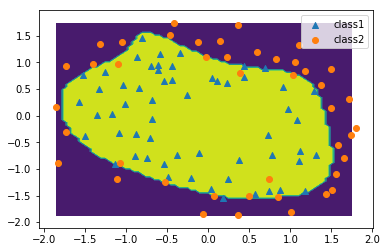

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# 迭代次数
iter_nums = 100
# 正则化强度lambda
lama = 0.1
lr = LogisticRegression(C=1/lama, max_iter=iter_nums, random_state=0)
lr.fit(X, Y)

# 绘制损耗函数
# 预测
z_predict = []
for _z in z:
    _z = extend_poly(_z[[0]], _z[[1]])
    z_predict.append(lr.predict(_z))
    
z_predict = np.array(z_predict).reshape(xy.shape)

# 绘制结果
plt.contourf(xy, yx, z_predict)
# 绘制原始数据
plt.scatter(X[Y == 1,0], X[Y == 1,1], marker='^', label='class1')
plt.scatter(X[Y == 0,0], X[Y == 0,1], marker='o', label='class2')
plt.legend()
plt.show()